In [1]:
%env PURE_PYTHON True
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from BTrees.OOBTree import OOBTree
import numpy as np
from collections import Counter
from scipy import stats
import pandas as pd
import pprint
import timeit

CHUNKS_SIZE = 10000
KEY_LENGTH = 8
ALPHABET = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

env: PURE_PYTHON=True


In [19]:
_debug_random_sampling = []

In [47]:
import os
os.environ["PURE_PYTHON"] = "True"

from BTrees.OOBTree import OOBTree as _OOBTree
from collections import Counter
import numpy as np



class OOBTreeExtLean(_OOBTree):

    def __init__(self):
        super(OOBTreeExtLean, self).__init__()
        self.walking_path_to_fanout_distribution = {}

    def random_sampling(self, k):
        self.walking_path_to_fanout_distribution = {}
        all_accept_reject_measures = {
            'accept': [],
            'reject': [],
            'revisited_paths': Counter()
        }

        k = min(len(self), k)
        sampled_values = []
        all_walking_paths_set = set()
        all_walking_paths_stats = []
        while len(sampled_values) < k:
            sampled_value, walking_path, walking_path_stats  = \
                self._get_value_and_path_by_random_walk_from_node(node=self)

            if _this_value_was_sampled_already(walking_path, all_walking_paths_set):
                all_accept_reject_measures['revisited_paths'][str(walking_path)] += 1
                continue

            accept_reject_measures = {
                'path': walking_path,
                'value': sampled_value,
            }

            all_accept_reject_measures['accept'].append(accept_reject_measures)

            all_walking_paths_set.add(str(walking_path))
            all_walking_paths_stats.append(walking_path_stats)
            sampled_values.append(sampled_value)

        add_to_debug_global(locals())

        return sampled_values

    def _get_value_and_path_by_random_walk_from_node(self, node):
        walking_path = []
        current_node = node
        prob_along_path = 1
        walking_path_stats = []
        while not isinstance(current_node, self._bucket_type):
            next_random_step, chosen_random_step_prob = self._random_next_move_respect_fanout_prob(current_node, walking_path)
            prob_along_path *= chosen_random_step_prob
            walking_path.append((next_random_step, current_node.size, chosen_random_step_prob, prob_along_path))
            current_node = current_node._data[next_random_step].child
            walking_path_stats.append({
                'next_random_step': next_random_step,
                'chosen_random_step_prob':
                    chosen_random_step_prob, 'prob_along_path':prob_along_path})

        next_random_step = np.random.randint(low=0, high=current_node.size)
        chosen_random_step_prob = 1/current_node.max_leaf_size  # todo: size
        prob_along_path *= chosen_random_step_prob
        walking_path.append((next_random_step, current_node.size, chosen_random_step_prob, prob_along_path))
        walking_path_stats.append({
            'next_random_step': next_random_step,
            'chosen_random_step_prob':
                chosen_random_step_prob, 'prob_along_path': prob_along_path,
            'entire_walking_path': walking_path})

        leaf = current_node._keys
        return leaf[next_random_step], walking_path, walking_path_stats


    def _random_next_move_respect_fanout_prob(self, current_node, walking_path):
        walking_path_str = str(walking_path)
        is_child_bucket = False #isinstance(current_node._data[0].child, self._bucket_type)
        if walking_path_str in self.walking_path_to_fanout_distribution:
            node_distribution = self.walking_path_to_fanout_distribution[walking_path_str]
        else:
            if not is_child_bucket:
                all_sizes = np.array([node.child.size for node in current_node._data])
            else:
                all_sizes = np.array([current_node.max_leaf_size] * len(current_node._data))
            node_distribution = all_sizes / sum(all_sizes)
            self.walking_path_to_fanout_distribution[walking_path_str] = node_distribution

        next_random_step = np.random.choice(current_node.size, p=node_distribution)
        chosen_random_step_prob = node_distribution[next_random_step] if not is_child_bucket else node_distribution[0]
        return next_random_step, chosen_random_step_prob


    def join(self, right_tree):
        pass


def add_to_debug_global(all_vars):
    global _debug_random_sampling
    _debug_random_sampling.append({
        'params': {
            'k': all_vars['k'],
        },
        'tree_size': len(all_vars['self']),
        'all_accept_reject_measures': all_vars['all_accept_reject_measures'],
        'all_walking_paths_stats': all_vars['all_walking_paths_stats']
    })


def _this_value_was_sampled_already(walking_path, all_walking_paths_set):
    return str(walking_path) in all_walking_paths_set




In [21]:
def generate_btree_index_x_values_with_dist(num_of_values, disired_prefix_to_percent_dist, my_index=None):
    my_index = my_index if my_index is not None else OOBTreeExt()
    for prefix, amount_percent in disired_prefix_to_percent_dist.items():
        amount = int(num_of_values * amount_percent)
        my_index = insert_to_index_random(my_index, amount, prefix)

    return my_index


def insert_to_index_random(my_index, amount, prefix=''):
    amount_in_iteration = min(CHUNKS_SIZE, amount)
    print('generating %s values, chunk of %s, with prefix=\'%s\'' %(amount, amount_in_iteration, prefix))

    proceed = 0
    for i in range(0, amount, amount_in_iteration):
        alphabet = list(ALPHABET)
        np_alphabet = np.array(alphabet)
        np_codes = np.random.choice(np_alphabet, [amount_in_iteration, KEY_LENGTH])
        my_index.update({
            prefix + ''.join(np_codes[i]): "".join(np_codes[i])
            for i in range(len(np_codes))
        })

        proceed += amount_in_iteration
        if (proceed % 150000) == 0:
            print('done generating %s values' % (proceed))
    return my_index


In [22]:
def _calculate_prefix_ditribution(values):
    return {value: occurences/len(values) for value, occurences in Counter([key[:4] for key in values]).most_common(10)}


In [23]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
num_of_values = 1_000_000
my_index = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())


generating 250000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
generating 150000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
generating 100000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 470000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values


In [24]:
len(my_index)

#my_index_items = my_index.items()

1000000

reminder: as n=1m<4, h=3
my theory  - with h=3, same probability to get to a bucket, different to choose in the bucket

In [25]:
# re-create index after doing a change in calss
#my_index = OOBTreeExtLean()
#my_index.update(my_index_items)
print(len(my_index))

1000000


In [26]:
random_values = my_index.random_sampling(k=10_000)
print(len(random_values))

10000


In [27]:
print(prefix_to_percent)
_calculate_prefix_ditribution(random_values)

{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}


{'gggg': 0.2489,
 'hhhh': 0.1433,
 'mmmm': 0.0971,
 'rrrr': 0.0284,
 'Zqxo': 0.0002,
 'LfYK': 0.0001,
 'hQmU': 0.0001,
 'PyOa': 0.0001,
 'ZvWG': 0.0001,
 'fttn': 0.0001}

In [28]:
_debug_random_sampling[-1]['all_walking_paths_stats'][0]

[{'next_random_step': 127,
  'chosen_random_step_prob': 0.0037813537246334187,
  'prob_along_path': 0.0037813537246334187},
 {'next_random_step': 20,
  'chosen_random_step_prob': 0.005555555555555556,
  'prob_along_path': 2.1007520692407882e-05},
 {'next_random_step': 11,
  'chosen_random_step_prob': 0.03333333333333333,
  'prob_along_path': 7.002506897469294e-07,
  'entire_walking_path': [(127,
    284,
    0.0037813537246334187,
    0.0037813537246334187),
   (20, 180, 0.005555555555555556, 2.1007520692407882e-05),
   (11, 18, 0.03333333333333333, 7.002506897469294e-07)]}]

In [33]:
all_walked_paths_1m = [x[-1]['entire_walking_path'] for x in _debug_random_sampling[-1]['all_walking_paths_stats']]

In [30]:
all_walked_paths_1m

[[(127, 284, 0.0037813537246334187, 0.0037813537246334187),
  (20, 180, 0.005555555555555556, 2.1007520692407882e-05),
  (11, 18, 0.03333333333333333, 7.002506897469294e-07)],
 [(95, 284, 0.004201504138481576, 0.004201504138481576),
  (178, 200, 0.005, 2.1007520692407882e-05),
  (8, 20, 0.03333333333333333, 7.002506897469294e-07)],
 [(236, 284, 0.003718331162556195, 0.003718331162556195),
  (116, 177, 0.005649717514124294, 2.1007520692407882e-05),
  (20, 21, 0.03333333333333333, 7.002506897469294e-07)],
 [(33, 284, 0.005209865131717155, 0.005209865131717155),
  (211, 248, 0.004032258064516129, 2.1007520692407882e-05),
  (0, 16, 0.03333333333333333, 7.002506897469294e-07)],
 [(227, 284, 0.003592286038401748, 0.003592286038401748),
  (77, 171, 0.005847953216374269, 2.1007520692407882e-05),
  (15, 24, 0.03333333333333333, 7.002506897469294e-07)],
 [(148, 284, 0.004033443972942313, 0.004033443972942313),
  (112, 192, 0.005208333333333333, 2.100752069240788e-05),
  (0, 24, 0.033333333333333

In [83]:
print(Counter([x[0][2]* x[1][2]* x[2][2] for x in all_walked_paths]))

Counter({7.002506897469294e-07: 8073, 7.002506897469293e-07: 1120, 7.002506897469295e-07: 807})


In [32]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
print(datetime.utcnow())
num_of_values = 4_000_000
my_index_4m = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
print(datetime.utcnow())

2020-12-20 10:50:37.898597
generating 1000000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
generating 600000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
generating 400000 values, chunk of 10000, with prefix='mmmm'
done generating 150000 values
done generating 300000 values
generating 120000 values, chunk of 10000, with prefix='rrrr'
generating 1880000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done g

In [45]:
random_values = my_index_4m.random_sampling(k=10_000)
print(len(random_values))
print(prefix_to_percent)
print(_calculate_prefix_ditribution(random_values))
random_values = my_index_4m.random_sampling(k=10_000)
print(len(random_values))
print(prefix_to_percent)
print(_calculate_prefix_ditribution(random_values))
random_values = my_index_4m.random_sampling(k=10_000)
print(len(random_values))
print(prefix_to_percent)
print(_calculate_prefix_ditribution(random_values))

10000
{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}
{'gggg': 0.2328, 'hhhh': 0.1479, 'mmmm': 0.1001, 'rrrr': 0.0282, 'Ekoq': 0.0002, 'Drzx': 0.0002, 'QjGn': 0.0002, 'WdJx': 0.0002, 'JOHu': 0.0001, 'XwhQ': 0.0001}
10000
{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}
{'gggg': 0.2272, 'hhhh': 0.1494, 'mmmm': 0.0976, 'rrrr': 0.0287, 'EmNs': 0.0002, 'rUrl': 0.0001, 'clMo': 0.0001, 'rPsJ': 0.0001, 'CBqi': 0.0001, 'utHu': 0.0001}
10000
{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}
{'gggg': 0.223, 'hhhh': 0.1537, 'mmmm': 0.1051, 'rrrr': 0.0312, 'Hvbz': 0.0002, 'qMHJ': 0.0002, 'PTpq': 0.0001, 'ZHcg': 0.0001, 'xgTc': 0.0001, 'kPVI': 0.0001}


In [35]:
print(prefix_to_percent)
_calculate_prefix_ditribution(random_values)

{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}


{'gggg': 0.2228,
 'hhhh': 0.1495,
 'mmmm': 0.104,
 'rrrr': 0.0286,
 'Xcxa': 0.0002,
 'hSvl': 0.0001,
 'REHu': 0.0001,
 'vkUd': 0.0001,
 'HLxc': 0.0001,
 'zsMQ': 0.0001}

In [36]:
all_walked_paths_4m = [x[-1]['entire_walking_path'] for x in _debug_random_sampling[-1]['all_walking_paths_stats']]

In [38]:
Counter([x[0][2]* x[1][2]* x[2][2] for x in all_walked_paths_4m])

Counter({4.7189125302373405e-06: 87,
         5.214738251272551e-06: 253,
         5.214738251272552e-06: 809,
         6.236207031976746e-06: 323,
         4.92849040450921e-06: 598,
         5.685550478043115e-06: 562,
         4.7813427452420894e-06: 951,
         5.685550478043114e-06: 947,
         4.928490404509211e-06: 1274,
         6.236207031976745e-06: 987,
         4.718912530237339e-06: 175,
         5.2147382512725525e-06: 82,
         5.059591315813838e-06: 903,
         4.71891253023734e-06: 873,
         5.059591315813839e-06: 219,
         6.2362070319767445e-06: 520,
         5.0595913158138375e-06: 203,
         4.9284904045092115e-06: 93,
         4.781342745242089e-06: 79,
         4.78134274524209e-06: 49,
         5.6855504780431135e-06: 13})

In [43]:
print(len(my_index._data))
len(my_index_4m._data)

284


7

## chaning last bucket calculation back as it shuold be

In [50]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
print(datetime.utcnow())
num_of_values = 4_000_000
my_index_4m_revert_stats = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
print(datetime.utcnow())

2020-12-20 11:07:01.026120
generating 1000000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
generating 600000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
generating 400000 values, chunk of 10000, with prefix='mmmm'
done generating 150000 values
done generating 300000 values
generating 120000 values, chunk of 10000, with prefix='rrrr'
generating 1880000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done g

In [52]:
print(datetime.utcnow())
print('')
print(len(random_values))
print(prefix_to_percent)
print('')
random_values = my_index_4m_revert_stats.random_sampling(k=10_000)
print(_calculate_prefix_ditribution(random_values))
print('')
random_values = my_index_4m_revert_stats.random_sampling(k=10_000)
print(_calculate_prefix_ditribution(random_values))
print('')
random_values = my_index_4m_revert_stats.random_sampling(k=10_000)
print(_calculate_prefix_ditribution(random_values))
print('')
print(datetime.utcnow())

2020-12-20 11:11:58.743723

10000
{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}

{'gggg': 0.2373, 'hhhh': 0.1521, 'mmmm': 0.1011, 'rrrr': 0.0268, 'SEXP': 0.0002, 'ViwH': 0.0002, 'ohXA': 0.0001, 'Ncnz': 0.0001, 'kGKP': 0.0001, 'Pfkq': 0.0001}

{'gggg': 0.224, 'hhhh': 0.1585, 'mmmm': 0.0988, 'rrrr': 0.0292, 'pWVP': 0.0002, 'nmdz': 0.0002, 'JvMq': 0.0001, 'lgcW': 0.0001, 'GbBD': 0.0001, 'PiXn': 0.0001}

{'gggg': 0.2219, 'hhhh': 0.1645, 'mmmm': 0.097, 'rrrr': 0.0311, 'JsRZ': 0.0002, 'jgZv': 0.0002, 'Dvxb': 0.0002, 'egru': 0.0001, 'cDlf': 0.0001, 'WdfU': 0.0001}

2020-12-20 11:12:07.730464


In [53]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
num_of_values = 1_000_000
my_index_revert_stats = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())

generating 250000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
generating 150000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
generating 100000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 470000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values


In [54]:
print(datetime.utcnow())
print('')
print(len(random_values))
print(prefix_to_percent)
print('')
random_values = my_index_revert_stats.random_sampling(k=10_000)
print(_calculate_prefix_ditribution(random_values))
print('')
random_values = my_index_revert_stats.random_sampling(k=10_000)
print(_calculate_prefix_ditribution(random_values))
print('')
random_values = my_index_revert_stats.random_sampling(k=10_000)
print(_calculate_prefix_ditribution(random_values))
print('')
print(datetime.utcnow())

2020-12-20 11:13:54.503719

10000
{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}

{'gggg': 0.2492, 'hhhh': 0.1513, 'mmmm': 0.0945, 'rrrr': 0.0255, 'Tlep': 0.0002, 'smWa': 0.0002, 'gsie': 0.0001, 'zqbo': 0.0001, 'CAEe': 0.0001, 'TYgq': 0.0001}

{'gggg': 0.2531, 'hhhh': 0.1494, 'mmmm': 0.0924, 'rrrr': 0.032, 'VryD': 0.0002, 'QwTi': 0.0002, 'hrEv': 0.0002, 'lWHp': 0.0001, 'cTfW': 0.0001, 'OyXV': 0.0001}

{'gggg': 0.2553, 'hhhh': 0.1476, 'mmmm': 0.0928, 'rrrr': 0.0278, 'fbxI': 0.0002, 'yKFi': 0.0001, 'Dveh': 0.0001, 'nWfm': 0.0001, 'MAwI': 0.0001, 'qFvF': 0.0001}

2020-12-20 11:13:59.451436


In [55]:
all_walked_paths_1m_revert_stats = [x[-1]['entire_walking_path'] for x in _debug_random_sampling[-1]['all_walking_paths_stats']]

In [59]:
Counter([x[0][2] * x[1][2]* x[2][2] for x in all_walked_paths_1m_revert_stats]).most_common(3)

[(6.464763510891083e-07, 11),
 (5.375189485927796e-07, 10),
 (5.617220597103388e-07, 10)]

In [60]:
[x for x in all_walked_paths_1m_revert_stats if x[0][2] * x[1][2]* x[2][2] == 6.464763510891083e-07]

[[(173, 286, 0.0033572537664190694, 0.0033572537664190694),
  (132, 160, 0.005776831863788386, 1.939429053267325e-05),
  (5, 19, 0.03333333333333333, 6.464763510891083e-07)],
 [(173, 286, 0.0033572537664190694, 0.0033572537664190694),
  (23, 160, 0.005776831863788386, 1.939429053267325e-05),
  (7, 19, 0.03333333333333333, 6.464763510891083e-07)],
 [(173, 286, 0.0033572537664190694, 0.0033572537664190694),
  (124, 160, 0.005776831863788386, 1.939429053267325e-05),
  (14, 19, 0.03333333333333333, 6.464763510891083e-07)],
 [(173, 286, 0.0033572537664190694, 0.0033572537664190694),
  (29, 160, 0.005776831863788386, 1.939429053267325e-05),
  (3, 19, 0.03333333333333333, 6.464763510891083e-07)],
 [(173, 286, 0.0033572537664190694, 0.0033572537664190694),
  (148, 160, 0.005776831863788386, 1.939429053267325e-05),
  (10, 19, 0.03333333333333333, 6.464763510891083e-07)],
 [(173, 286, 0.0033572537664190694, 0.0033572537664190694),
  (132, 160, 0.005776831863788386, 1.939429053267325e-05),
  (15,

In [73]:
len(my_index_4m._data[0].child._data[0].child._data[0].child._keys)

20

In [82]:
max([x[-1][1] for x in all_walked_paths])

30

In [108]:
curr = my_index_4m._firstbucket
all_sizes = []
while curr:
    all_sizes.append(curr.size)
    curr = curr._next

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

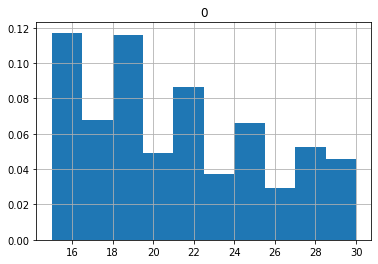

In [164]:
pd.DataFrame(all_sizes).hist(density=1)


In [110]:
min([x[1][1] for x in all_walked_paths_1m_revert_stats])

125

In [176]:
#second_level_size_0 = 
for i in range(0,7):
    node_children_sizes = [x.child.size for x in my_index_4m._data[i].child._data]
    #print("%s  -  %s  - %s " % (np.mean(node_children_sizes),len(node_children_sizes), np.mean(node_children_sizes) / len(node_children_sizes)))
    print("mean %s  - std %s - len  %s  - mean/n %s" % (np.mean(node_children_sizes),np.std(node_children_sizes),len(node_children_sizes), np.mean(node_children_sizes) / len(node_children_sizes)))

mean 141.28095238095239  - std 15.053305887431822 - len  210  - mean/n 0.6727664399092971
mean 174.1360544217687  - std 28.733738839519624 - len  147  - mean/n 1.184599009671896
mean 186.7076923076923  - std 14.120604777768579 - len  130  - mean/n 1.4362130177514791
mean 184.26984126984127  - std 9.004771837632568 - len  126  - mean/n 1.462459057697153
mean 168.955223880597  - std 22.50401810610778 - len  134  - mean/n 1.2608598797059478
mean 154.96428571428572  - std 25.052775926684312 - len  168  - mean/n 0.9224064625850341
mean 178.76818181818183  - std 24.981008902466773 - len  220  - mean/n 0.8125826446280993


In [175]:
for i in range(0,20):
    node_children_sizes = [x.child.size for x in my_index_4m._data[-1].child._data[i].child._data]
    print("mean %s  - std %s - len  %s  - mean/n %s" % (np.mean(node_children_sizes),np.std(node_children_sizes),len(node_children_sizes), np.mean(node_children_sizes) / len(node_children_sizes)))

mean 21.71590909090909  - std 4.191302855688094 - len  176  - mean/n 0.12338584710743801
mean 20.497206703910614  - std 4.452573547052352 - len  179  - mean/n 0.1145095346587185
mean 20.779761904761905  - std 4.016966391560889 - len  168  - mean/n 0.1236890589569161
mean 21.301075268817204  - std 4.413529897443194 - len  186  - mean/n 0.11452191004740432
mean 20.80952380952381  - std 4.414468070410204 - len  189  - mean/n 0.11010330057949105
mean 20.570652173913043  - std 3.959771569044989 - len  184  - mean/n 0.11179702268431002
mean 20.821229050279328  - std 4.419534676591172 - len  179  - mean/n 0.11631971536468898
mean 21.02185792349727  - std 4.301424702539561 - len  183  - mean/n 0.11487354056555885
mean 21.485714285714284  - std 4.527827789326348 - len  175  - mean/n 0.12277551020408162
mean 20.564766839378237  - std 4.432241982009432 - len  193  - mean/n 0.1065531960589546
mean 20.96842105263158  - std 4.217638729703343 - len  190  - mean/n 0.11036011080332411
mean 21.032967032

In [151]:
for i in range(0,7):
    print(np.mean([x.child.size for x in my_index_4m._data[6].child._data[i].child._data]))

21.71590909090909
20.497206703910614
20.779761904761905
21.301075268817204
20.80952380952381
20.570652173913043
20.821229050279328


In [188]:
my_index_4m._data[0].child.keys()

In [181]:
len(my_index_4m._data[1].child)

3376171

In [189]:
len(my_index_4m._data[2].child)

2838508

In [197]:
len(my_index_4m._data[1].child.values())

3376171

In [196]:
len(my_index_4m._data[0].child.values())

4000000

In [199]:
len(my_index_4m._data[3].child.values())

2329592

# creating different size of trees, and exploring there leaf level distribution

In [205]:
#my_index_size ={}
num_of_values = 30_000
my_index_size[num_of_values] = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())

generating 7500 values, chunk of 7500, with prefix='gggg'
generating 4500 values, chunk of 4500, with prefix='hhhh'
generating 3000 values, chunk of 3000, with prefix='mmmm'
generating 900 values, chunk of 900, with prefix='rrrr'
generating 14100 values, chunk of 10000, with prefix=''


In [245]:
curr_index = my_index_size[num_of_values]
first_bucket = curr_index._data[0].child


In [287]:
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}

for num_of_values in (30_000, 100_000, 400_000, 800_000, 1_000_000, 3_000_000):
    my_index_size[num_of_values] = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
    curr_index = my_index_size[num_of_values]
    print('======')
    print(f'---Tree with {num_of_values} values----')
    for node_level_1 in curr_index._data:
        assert isinstance(node_level_1.child._data[0].child, curr_index._bucket_type)
        child_buckets_size = [x.child.size for x in node_level_1.child._data]
        print("mean %s  - std %s - len  %s  - mean/n %s" % (
            np.mean(child_buckets_size),np.std(child_buckets_size),len(child_buckets_size), 
            np.mean(child_buckets_size) / len(child_buckets_size)))
    print('\n\n')

generating 7500 values, chunk of 7500, with prefix='gggg'
generating 4500 values, chunk of 4500, with prefix='hhhh'
generating 3000 values, chunk of 3000, with prefix='mmmm'
generating 900 values, chunk of 900, with prefix='rrrr'
generating 14100 values, chunk of 10000, with prefix=''
---Tree with 30000 values----
mean 20.62251655629139  - std 3.957960746343177 - len  151  - mean/n 0.13657295732643304
mean 20.804054054054053  - std 4.232529726885572 - len  148  - mean/n 0.14056793279766253
mean 21.034246575342465  - std 4.166754236898002 - len  146  - mean/n 0.1440701820228936
mean 20.293333333333333  - std 4.154590499943673 - len  150  - mean/n 0.13528888888888888
mean 22.13533834586466  - std 4.096178220407606 - len  133  - mean/n 0.16643111538244107
mean 20.642857142857142  - std 4.273328663756245 - len  126  - mean/n 0.16383219954648526
mean 21.41830065359477  - std 4.4539978063114285 - len  153  - mean/n 0.13998889316075014
mean 20.792  - std 4.44935231241582 - len  125  - mean/n 

done generating 150000 values
generating 120000 values, chunk of 10000, with prefix='hhhh'
generating 80000 values, chunk of 10000, with prefix='mmmm'
generating 24000 values, chunk of 10000, with prefix='rrrr'
generating 376000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
---Tree with 800000 values----
mean 20.923444976076556  - std 4.24983822918533 - len  209  - mean/n 0.10011217691902659
mean 20.313725490196077  - std 4.5750396808669445 - len  204  - mean/n 0.09957708573625527
mean 20.56122448979592  - std 4.341462009297762 - len  196  - mean/n 0.10490420658059142
mean 20.641414141414142  - std 4.488785354614321 - len  198  - mean/n 0.1042495663707785
mean 21.028985507246375  - std 4.204797172356774 - len  207  - mean/n 0.1015893019673738
mean 21.27319587628866  - std 4.524002777030639 - len  194  - mean/n 0.10965564884684877
mean 20.60576923076923  - std 4.163528157221509 - len  208  - mean/n 0.09906619822485206
mean 21.10447761

done generating 150000 values
generating 150000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
generating 100000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 470000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
---Tree with 1000000 values----
mean 21.598484848484848  - std 4.084078191466571 - len  132  - mean/n 0.1636248852157943
mean 20.955555555555556  - std 4.5196962642402925 - len  135  - mean/n 0.15522633744855968
mean 20.827067669172934  - std 4.173873767677168 - len  133  - mean/n 0.15659449375317996
mean 20.874074074074073  - std 4.319515798704037 - len  135  - mean/n 0.1546227709190672
mean 21.2406015037594  - std 4.645557949347917 - len  133  - mean/n 0.1597037707049579
mean 20.466165413533833  - std 4.45790481853691 - len  133  - mean/n 0.153880942958901
mean 21.48175182481752  - std 4.57237370636651

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
generating 450000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
done generating 300000 values
done generating 450000 values
generating 300000 values, chunk of 10000, with prefix='mmmm'
done generating 150000 values
done generating 300000 values
generating 90000 values, chunk of 10000, with prefix='rrrr'
generating 1410000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
---Tree with 3000000 values----


AssertionError: 

In [277]:
np.mean(child_buckets_size)

20.618357487922705

## let's try with different values distributions

In [288]:
prefix_to_percent = {
    'gggg': 0.9,
    'hhhh': 0.01,
    'mmmm': 0.01,
    'rrrr': 0.01,
    '': 0.07
}

for num_of_values in (30_000, 100_000, 400_000, 800_000, 1_000_000, 3_000_000):
    my_index_size[num_of_values] = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
    curr_index = my_index_size[num_of_values]
    print('======')
    print(f'---Tree with {num_of_values} values----')
    for node_level_1 in curr_index._data:
        assert isinstance(node_level_1.child._data[0].child, curr_index._bucket_type)
        child_buckets_size = [x.child.size for x in node_level_1.child._data]
        print("mean %s  - std %s - len  %s  - mean/n %s" % (
            np.mean(child_buckets_size),np.std(child_buckets_size),len(child_buckets_size), 
            np.mean(child_buckets_size) / len(child_buckets_size)))
    print('\n\n')

generating 27000 values, chunk of 10000, with prefix='gggg'
generating 300 values, chunk of 300, with prefix='hhhh'
generating 300 values, chunk of 300, with prefix='mmmm'
generating 300 values, chunk of 300, with prefix='rrrr'
generating 2100 values, chunk of 2100, with prefix=''
---Tree with 30000 values----
mean 20.776371308016877  - std 4.227271156638833 - len  237  - mean/n 0.08766401395787712
mean 20.854748603351954  - std 4.183115478252721 - len  179  - mean/n 0.11650697543772041
mean 20.696132596685082  - std 4.2687916004736595 - len  181  - mean/n 0.11434327401483471
mean 20.92817679558011  - std 4.255686023046622 - len  181  - mean/n 0.11562528616342603
mean 21.06111111111111  - std 4.41608661460057 - len  180  - mean/n 0.11700617283950616
mean 21.269662921348313  - std 4.3389121117331095 - len  178  - mean/n 0.11949248832218154
mean 20.581920903954803  - std 4.189752191809447 - len  177  - mean/n 0.11628203900539437
mean 21.512  - std 4.309275577170716 - len  125  - mean/n 0

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
generating 8000 values, chunk of 8000, with prefix='hhhh'
generating 8000 values, chunk of 8000, with prefix='mmmm'
generating 8000 values, chunk of 8000, with prefix='rrrr'
generating 56000 values, chunk of 10000, with prefix=''
---Tree with 800000 values----
mean 21.604545454545455  - std 4.324662600893884 - len  220  - mean/n 0.09820247933884298
mean 21.483870967741936  - std 4.460886620344871 - len  217  - mean/n 0.09900401367623012
mean 21.417040358744394  - std 4.372875651643765 - len  223  - mean/n 0.09604053972531118
mean 21.184549356223176  - std 4.208648553989445 - len  233  - mean/n 0.09092081268765312
mean 20.132530120481928  - std 4.173268587920514 - len  249  - mean/n 0.08085353462040935
mean 20.69527896995708  - std 4.357108939736726 - len  233  - mean/n 0.08882093978522351
mean 20.889400921658986  - std 4.332571751525757 - len  217  - mean/n 0.09626452

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
generating 10000 values, chunk of 10000, with prefix='hhhh'
generating 10000 values, chunk of 10000, with prefix='mmmm'
generating 10000 values, chunk of 10000, with prefix='rrrr'
generating 70000 values, chunk of 10000, with prefix=''
---Tree with 1000000 values----
mean 21.496350364963504  - std 4.215238410261819 - len  137  - mean/n 0.15690766689754382
mean 20.711409395973153  - std 4.13415192120013 - len  149  - mean/n 0.13900274762398088
mean 20.46808510638298  - std 3.9167818449749916 - len  141  - mean/n 0.14516372415874454
mean 21.612676056338028  - std 4.532897887803969 - len  142  - mean/n 0.1522019440587185
mean 21.31654676258993  - std 4.472193820884138 - len  139  - mean/n 0.15335645152942395
mean 21.091549295774648  - std 4.55468328791407 - len  142  - mean/n 0.14853203729418765
mean 21.18571428

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done generating 1650000 values
done generating 1800000 values
done generating 1950000 values
done generating 2100000 values
done generating 2250000 values
done generating 2400000 values
done generating 2550000 values
done generating 2700000 values
generating 30000 values, chunk of 10000, with prefix='hhhh'
generating 30000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 210000 values, chunk of 10000, with prefix=''
done generating 150000 values
---Tree with 3000000 values----


AssertionError: 

In [ ]:
## let's try with random data only

In [290]:
prefix_to_percent = {
#     'gggg': 0.0,
#     'hhhh': 0.0,
#     'mmmm': 0.0,
#     'rrrr': 0.0,
    '': 1.0
}

for num_of_values in (30_000, 100_000, 400_000, 800_000, 1_000_000, 3_000_000):
    my_index_size[num_of_values] = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
    curr_index = my_index_size[num_of_values]
    print('======')
    print(f'---Tree with {num_of_values} values----')
    for node_level_1 in curr_index._data:
        assert isinstance(node_level_1.child._data[0].child, curr_index._bucket_type)
        child_buckets_size = [x.child.size for x in node_level_1.child._data]
        print("mean %s  - std %s - len  %s  - mean/n %s" % (
            np.mean(child_buckets_size),np.std(child_buckets_size),len(child_buckets_size), 
            np.mean(child_buckets_size) / len(child_buckets_size)))
    print('\n\n')

generating 30000 values, chunk of 10000, with prefix=''
---Tree with 30000 values----
mean 20.876404494382022  - std 4.340352144153824 - len  178  - mean/n 0.11728317131675293
mean 20.443243243243245  - std 3.9753660746300095 - len  185  - mean/n 0.11050401753104457
mean 21.124260355029588  - std 4.600225446330574 - len  169  - mean/n 0.12499562340254194
mean 20.329787234042552  - std 4.363505076251811 - len  188  - mean/n 0.10813716613852421
mean 20.704918032786885  - std 4.437831384545042 - len  183  - mean/n 0.11314162859446386
mean 21.28491620111732  - std 4.714454934366568 - len  179  - mean/n 0.11891014637495709
mean 20.876404494382022  - std 4.4135140391147445 - len  178  - mean/n 0.11728317131675293
mean 20.737704918032787  - std 4.261538394370879 - len  183  - mean/n 0.11332079190181851



generating 100000 values, chunk of 10000, with prefix=''
---Tree with 100000 values----
mean 20.654929577464788  - std 4.087159168109703 - len  142  - mean/n 0.1454572505455267
mean 21.3125 

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
---Tree with 800000 values----
mean 20.815068493150687  - std 3.9948655825579347 - len  146  - mean/n 0.142568962281854
mean 20.321678321678323  - std 4.01500925044245 - len  143  - mean/n 0.14210963861313514
mean 20.566433566433567  - std 4.308974924843406 - len  143  - mean/n 0.14382121375128368
mean 20.614864864864863  - std 4.254605848687331 - len  148  - mean/n 0.13928962746530313
mean 21.026845637583893  - std 4.54204268968976 - len  149  - mean/n 0.14111976937975768
mean 20.819444444444443  - std 4.402733964030157 - len  144  - mean/n 0.14457947530864196
mean 20.73103448275862  - std 4.139390547201268 - len  145  - mean/n 0.14297265160523187
mean 20.96  - std 4.234587740658273 - len  150  - mean/n 0.13973333333333335
mean 21.432835820895523  - std 4.527606466592343 - len  134  - mean/n 0.15994653597683225
mean 20.562962962962963  -

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
---Tree with 1000000 values----
mean 20.5752688172043  - std 4.488603392104083 - len  186  - mean/n 0.11061972482367903
mean 20.89010989010989  - std 4.475698851319689 - len  182  - mean/n 0.11478082357203237
mean 20.345  - std 3.974415051300002 - len  200  - mean/n 0.101725
mean 20.96842105263158  - std 4.555973826409147 - len  190  - mean/n 0.11036011080332411
mean 20.972677595628415  - std 4.305837559961677 - len  183  - mean/n 0.11460479560452685
mean 21.25925925925926  - std 4.160977891967311 - len  189  - mean/n 0.11248285322359397
mean 20.34517766497462  - std 4.106777806651674 - len  197  - mean/n 0.10327501352778995
mean 21.581521739130434  - std 4.31174909903228 - len  184  - mean/n 0.11729087901701322
mean 21.054945054945055  - std 4.266822266011123 - len  182  - mean/n 0.11568651129090689
mean 21.

done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done generating 1650000 values
done generating 1800000 values
done generating 1950000 values
done generating 2100000 values
done generating 2250000 values
done generating 2400000 values
done generating 2550000 values
done generating 2700000 values
done generating 2850000 values
done generating 3000000 values
---Tree with 3000000 values----


AssertionError: 

In [292]:
### le'ts try on Huge data set

In [298]:
datetime.now()

datetime.datetime(2020, 12, 21, 19, 58, 17, 35833)

In [299]:

for num_of_values in (100_000_000,):
    print(datetime.now())
    my_index_size_huge[num_of_values] = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExtLean())
    print(datetime.now())
    curr_index = my_index_size_huge[num_of_values]
    print('======')
    print(f'---Tree with {num_of_values} values----')
    for node_level_1 in curr_index._data:
        assert isinstance(node_level_1.child._data[0].child, curr_index._bucket_type)
        child_buckets_size = [x.child.size for x in node_level_1.child._data]
        print("mean %s  - std %s - len  %s  - mean/n %s" % (
            np.mean(child_buckets_size),np.std(child_buckets_size),len(child_buckets_size), 
            np.mean(child_buckets_size) / len(child_buckets_size)))
    print('\n\n')

2020-12-21 19:58:48.488214
generating 100000000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done generating 1650000 values
done generating 1800000 values
done generating 1950000 values
done generating 2100000 values
done generating 2250000 values
done generating 2400000 values
done generating 2550000 values
done generating 2700000 values
done generating 2850000 values
done generating 3000000 values
done generating 3150000 values
done generating 3300000 values
done generating 3450000 values
done generating 3600000 values
done generating 3750000 values
done generating 3900000 values
done generating 4050000 values
done generating 4200000 values
done generating 4350000 values
done generating 4500

done generating 38550000 values
done generating 38700000 values
done generating 38850000 values
done generating 39000000 values
done generating 39150000 values
done generating 39300000 values
done generating 39450000 values
done generating 39600000 values
done generating 39750000 values
done generating 39900000 values
done generating 40050000 values
done generating 40200000 values
done generating 40350000 values
done generating 40500000 values
done generating 40650000 values
done generating 40800000 values
done generating 40950000 values
done generating 41100000 values
done generating 41250000 values
done generating 41400000 values
done generating 41550000 values
done generating 41700000 values
done generating 41850000 values
done generating 42000000 values
done generating 42150000 values
done generating 42300000 values
done generating 42450000 values
done generating 42600000 values
done generating 42750000 values
done generating 42900000 values
done generating 43050000 values
done gen

done generating 77100000 values
done generating 77250000 values
done generating 77400000 values
done generating 77550000 values
done generating 77700000 values
done generating 77850000 values
done generating 78000000 values
done generating 78150000 values
done generating 78300000 values
done generating 78450000 values
done generating 78600000 values
done generating 78750000 values
done generating 78900000 values
done generating 79050000 values
done generating 79200000 values
done generating 79350000 values
done generating 79500000 values
done generating 79650000 values
done generating 79800000 values
done generating 79950000 values
done generating 80100000 values
done generating 80250000 values
done generating 80400000 values
done generating 80550000 values
done generating 80700000 values
done generating 80850000 values
done generating 81000000 values
done generating 81150000 values
done generating 81300000 values
done generating 81450000 values
done generating 81600000 values
done gen

NameError: name 'my_index_size_huge' is not defined